In [1]:
import pandas as pd 
import numpy as np
import pingouin as pg
from scipy import stats
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
pd.set_option('display.max_rows',200)

# 1- EDA analysis (Trends on Tableau)

In [2]:
df = pd.read_csv('/Users/Marcy_Student/Desktop/Mod 4 Project, Statistic/hour.csv')
df.duplicated().sum()
df.isna().sum()
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [3]:
# Changing data types
df['dteday'] = pd.to_datetime(df['dteday'])
df['season']=df['season'].astype('category')
df['yr']= df['season'].astype('category')
df['holiday'] =df['holiday'].astype('bool')
df['weekday'] =df['weekday'].astype('category')
df['workingday'] = df['workingday'].astype('bool')
df['weathersit'] = df['weathersit'].astype('category')

df.dtypes

instant                int64
dteday        datetime64[ns]
season              category
yr                  category
mnth                   int64
hr                     int64
holiday                 bool
weekday             category
workingday              bool
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

## Questions of interests supported by statistical tests


array([[<Axes: title={'center': 'instant'}>,
        <Axes: title={'center': 'dteday'}>,
        <Axes: title={'center': 'mnth'}>, <Axes: title={'center': 'hr'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'hum'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'cnt'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

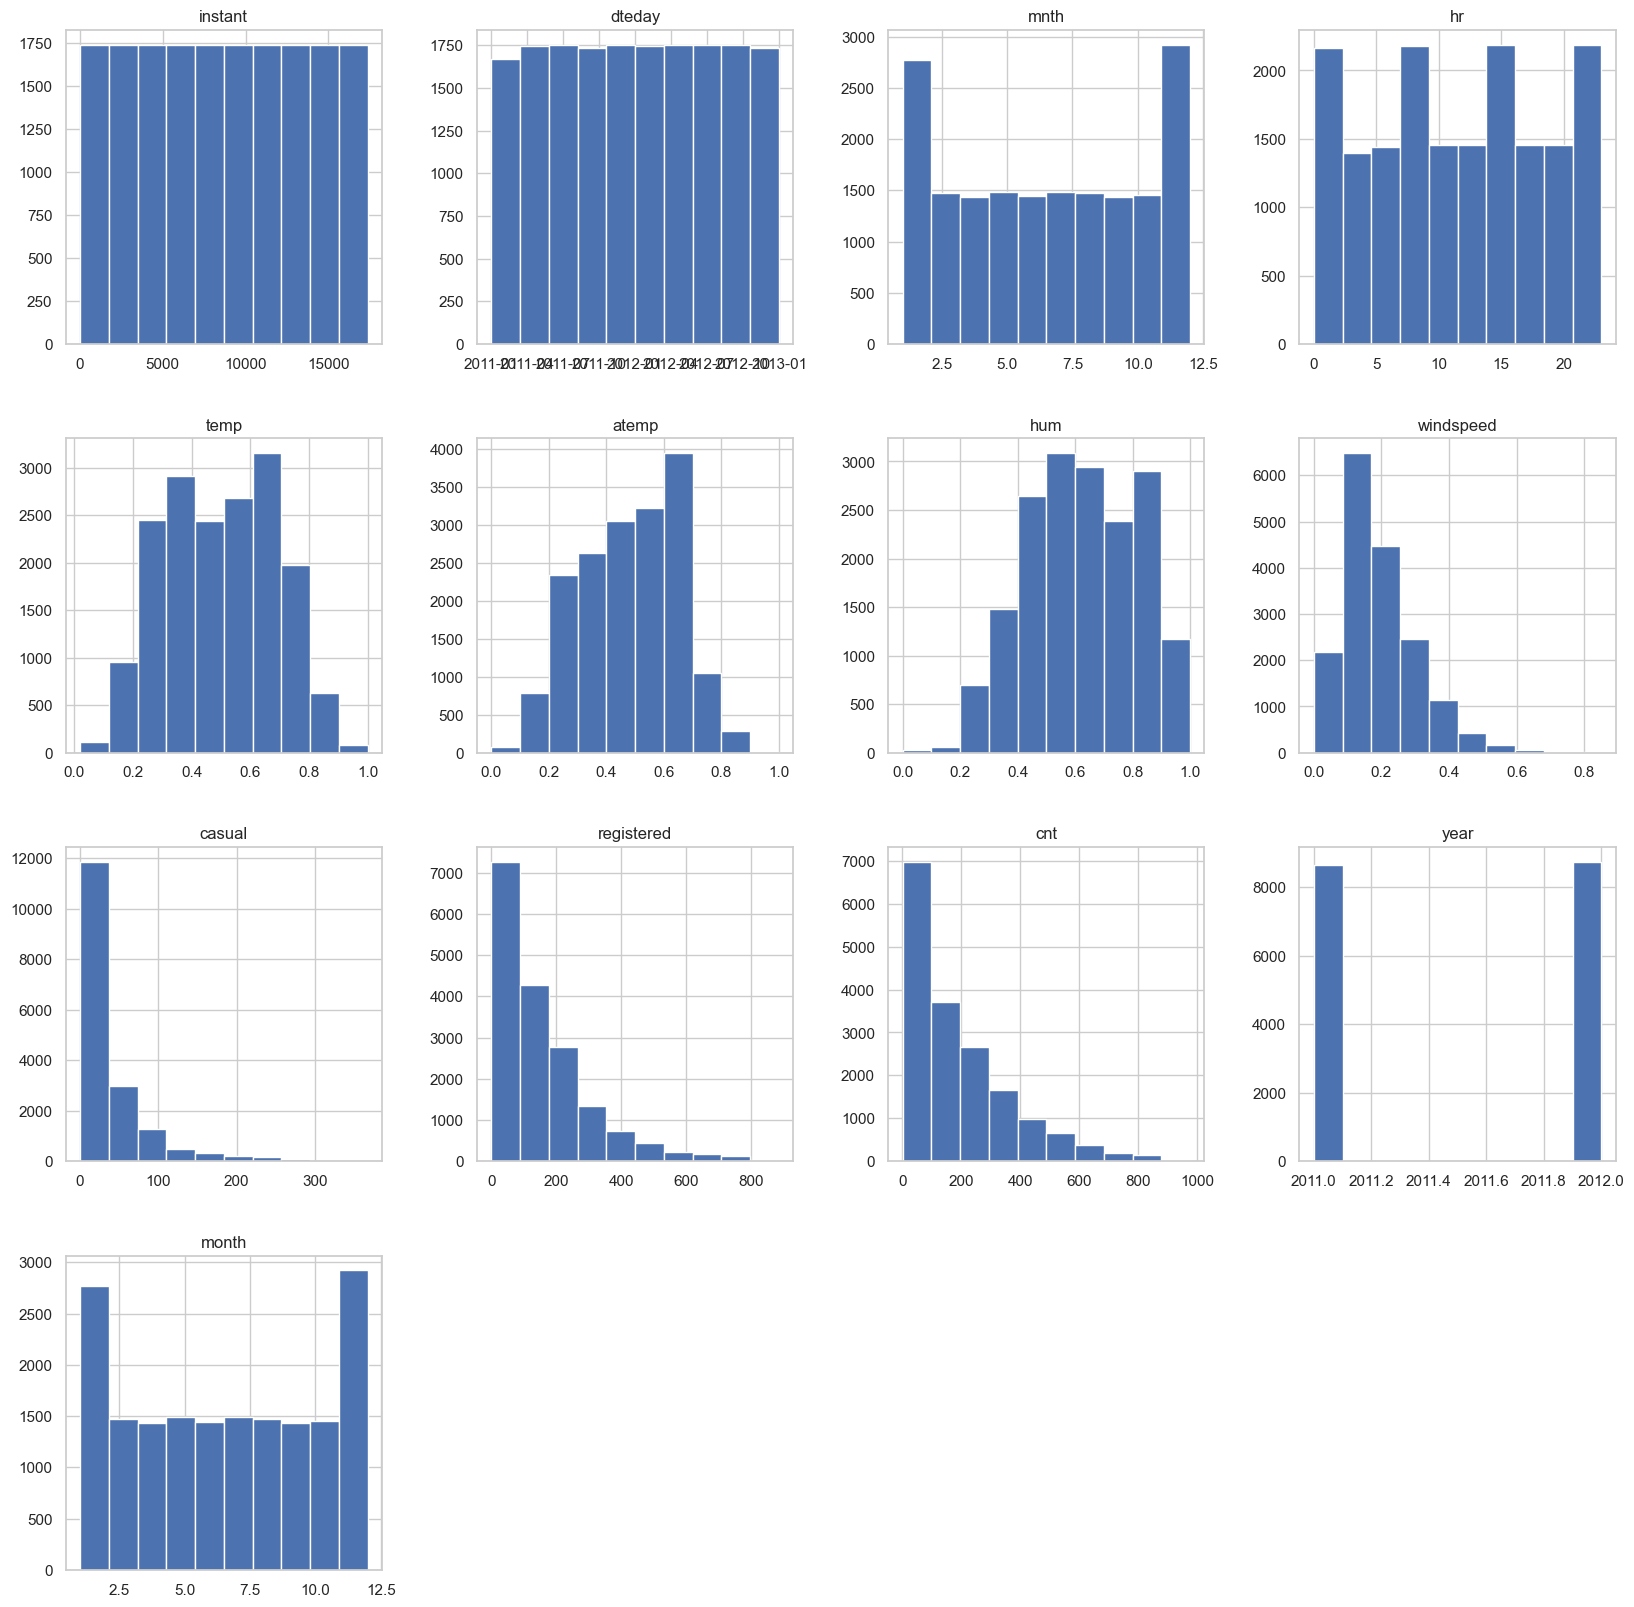

In [73]:
#distribution of the varibles on my dataframe
df.hist(figsize=(20,20))

### 1- Is the mean number of casuals users significantly higher on holidays, compared to non_holidays
 - METHOD USED: Hypothesis testing TTEST with 95% Confidence level
 - NULL HYPOTHESIS : The mean number of casuals users are statistically the same on both holidays and non_holidays
 - ALTERNATIVE HYPOTHESIS : The mean number of casuals users are significantly higher on holidays compared to non-holidays
 - WHY IS IT IMPORTANT: This information is useful for incorporating new feature product such as holiday pass, or tailord offers.

 **Note** The distribution of registered , cnt and casual are skewed, not normaly distributed. But thanks to the central limit theorem, we can still apply them for a t-test. However, we will be careful with variants that have a very big difference on their size when comparing them. we will need to use a sampling technique to balance the sizes.

In [ ]:
# Get the length of non-holiday and holiday rows
num_holiday = df[df['holiday'] == True].shape[0]
num_non_holiday = df[df['holiday'] == False].shape[0]
print(f"Number of holiday rows: {num_holiday}")
print(f"Number of non-holiday rows: {num_non_holiday}")
# The number of holiday rows is significantly smaller than non-holiday rows.
# I will need to do a balanced sampling for the t-test.

Number of holiday rows: 500
Number of non-holiday rows: 16879


In [ ]:
# creating a balacing sampling function for t-test
def balanced_sampling_ttest(sample1, sample2, n_iter=1000, alternative='two-sided'): # sample 1 is the smaller sample
    """
    Running Welch's t-test n_iter times by sampling sample2 to match sample1's size.
    I will then compute the average mean difference, average p-value, confidence interval
    as the average results of all thousands samples.
    """
    n = len(sample1)
    pg_tables = []
    for _ in range(n_iter):
        sample2_balanced = np.random.choice(sample2, size=n, replace=False)
        res = pg.ttest(sample1, sample2_balanced, correction=False, alternative=alternative)
        pg_tables.append(res)
    # Return the last table after 1000 sampling and summary stats
    final_table = pg_tables[-1]
    print(f"Mean difference: {np.mean(sample1) - np.mean(sample2_balanced):.2f}")
    print(f"Sample1 mean: {np.mean(sample1):.2f}, Sample2 mean: {np.mean(sample2_balanced):.2f}")
    print(f"Power: {final_table['power'][0]:.3f}")
    print(f"95% CI: {final_table['CI95%'][0]}")
    print(f"p-value: {final_table['p-val'][0]:.4f}")
    return final_table

In [ ]:
# grouping to see the means
is_holiday_riders_means = df.groupby('holiday')['casual'].mean() # 1 is holiday, 0 is not holiday
print(is_holiday_riders_means)

# subsetting the data into the two groups
holiday_riders = df.loc[df['holiday']==True,'casual'] # treatment _ True boolean
not_holiday_riders = df.loc[df['holiday']==False,'casual'] # control_False boolean

# running the test with the balancing function 
balanced_sampling_ttest(holiday_riders, not_holiday_riders,n_iter=1000, alternative='greater')

# running the test without balancing to see the difference 

ttest_holiday = pg.ttest(holiday_riders, not_holiday_riders,alternative='greater', correction='auto')
print(ttest_holiday)
alpha = 0.05
if (ttest_holiday['p-val']).mean()<alpha:
    print(f'Casual users mean is significantly higher on holidays compared to not holidays, We reject the null hypothesis')
else:
    print('We fail to reject to Null hypothesis')



holiday
False    35.408377
True     44.718000
Name: casual, dtype: float64
Mean difference: 11.02
Sample1 mean: 44.72, Sample2 mean: 33.70
Power: 0.955
95% CI: [5.6 inf]
p-value: 0.0004
               T         dof alternative     p-val        CI95%   cohen-d  \
T-test  3.490448  519.533224     greater  0.000262  [4.91, inf]  0.188906   

          BF10     power  
T-test  42.909  0.994096  
Casual users mean is significantly higher on holidays compared to not holidays, We reject the null hypothesis


Mean difference: 10.18
Sample1 mean: 44.72, Sample2 mean: 34.54
Power: 0.905
95% CI: [4.51  inf]
p-value: 0.0016


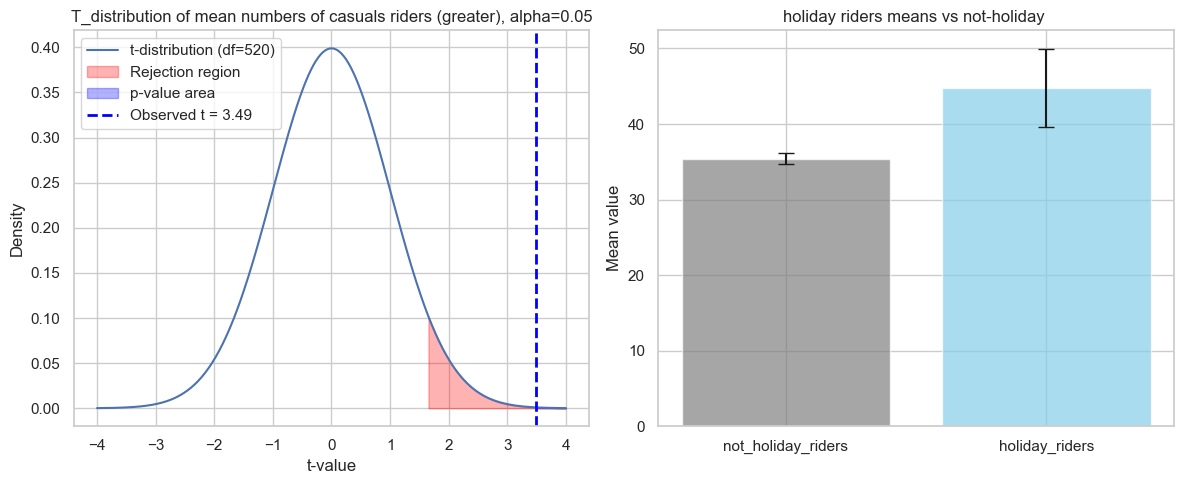

T-statistic = 3.490
p-value = 0.0003
95% CI of mean difference = [4.910, inf]


In [72]:
# Defining a function to plot the ttest results
def plot_ttest_with_means(pg_results, control, treatment, alpha=0.05):
    """
    I show side-by-side:
    (1) t-distribution with rejection region and observed t
    (2) group means with 95% CI
    """
    # Extracting results from Pingouin
    t_stat = pg_results["T"].values[0]
    dfree = pg_results["dof"].values[0]
    pval = pg_results["p-val"].values[0]
    ci_low, ci_high = pg_results["CI95%"].values[0]

    # Critical t, I use scipy.stats t
    t_crit = t.ppf(1 - alpha, dfree)

    # Setting up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # -----------------------------
    # (1) t-distribution visualization
    # -----------------------------
    ax = axes[0]
    x = np.linspace(-4, 4, 400)
    y = t.pdf(x, dfree) # getting density of my curve
    ax.plot(x, y, label=f't-distribution (df={dfree:.0f})') # ploting

    # Rejection region
    ax.fill_between(x, y, where=(x >= t_crit), color='red', alpha=0.3, label='Rejection region')

    # p-value area
    ax.fill_between(x, y, where=(x >= t_stat), color='blue', alpha=0.3, label='p-value area')

    # Observed t
    ax.axvline(t_stat, color='blue', linestyle='--', linewidth=2, label=f'Observed t = {t_stat:.2f}')

    ax.set_title(f"T_distribution of mean numbers of casuals riders (greater), alpha={alpha}")
    ax.set_xlabel("t-value")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

    # -----------------------------
    # (2) control treatment means
    # -----------------------------
    ax = axes[1]

    means = [control.mean(), treatment.mean()]
    errors = [
        1.96 * control.std(ddof=1) / np.sqrt(len(control)),
        1.96 * treatment.std(ddof=1) / np.sqrt(len(treatment))
    ]

    ax.bar([0, 1], means, yerr=errors, capsize=6, alpha=0.7, color=['gray', 'skyblue'])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["not_holiday_riders", "holiday_riders"])
    ax.set_ylabel("Mean value")

    ax.set_title("holiday riders means vs not-holiday ")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"T-statistic = {t_stat:.3f}")
    print(f"p-value = {pval:.4f}")
    print(f"95% CI of mean difference = [{ci_low:.3f}, {ci_high:.3f}]")
    
pg_results = balanced_sampling_ttest(holiday_riders, not_holiday_riders, alternative='greater')
plot_ttest_with_means(ttest_holiday, not_holiday_riders, holiday_riders)

### 2- Do registered users ride significantly more on commuting hours ? 7-9 am , 5-7 pm.
- Null hypothesis : Registered users do not ride more during commuting hours compared to not commuting hours
- Alt hypothesis : Registered users DO ride more during commuting hours 7-9 am, 5-7 pm.
- So what ? : verifying this hyppthesis is relevant for all product management, marketing, operational and ethics advisor teams. if the hypothesis hold True, then it means that registered riders are stable, predictable and monetizable segment. Based on this evidence, marketing can create subscription plans, promotions, customers loyalty programs, but also incorporate dynamic pricing based on peak times. For example, the MTA has a treashold weekly price for any user paying with the same device. The same policy can apply to discount regular, repeated users when they reach a certain number of rides. Additionnaly, Operational team can take advantage of this evidence by optimizing the bike distribution to match the demand volume or planning maintenance. For example, having more bikes on residential areas during morning times, and more on business districts during evening time.

In [6]:
# Creating a feature for commuting hours
commuting_hour = [7, 8, 9, 17, 18, 19]
df['commuting_hours'] = df['hr'].isin(commuting_hour)

# getting our control and treatment
commuting_hours_means = df.groupby('commuting_hours')['registered'].mean()
riders_on_commute_hours = df.loc[df['commuting_hours']==True,'registered']
riders_not_commute_hours = df.loc[df['commuting_hours']==False,'registered']
print(commuting_hours_means)
commute_ttest = pg.ttest (riders_on_commute_hours, riders_not_commute_hours, alternative = 'greater', correction='auto')
commute_ttest

commuting_hours
False    107.985552
True     290.257385
Name: registered, dtype: float64


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,59.548456,5131.7953,greater,0.0,"[177.24, inf]",1.412192,inf,1.0


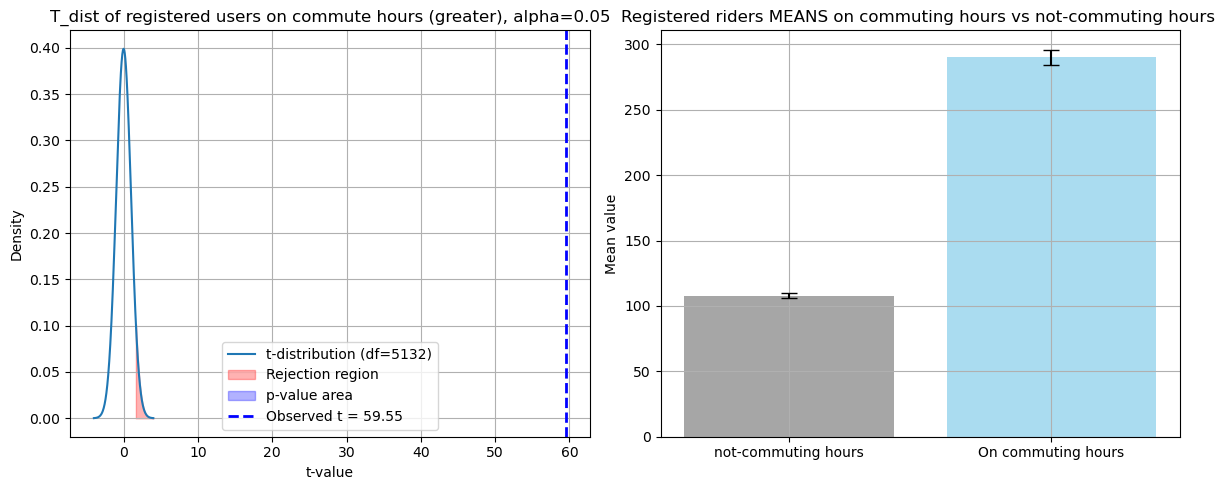

T-statistic = 59.548
p-value = 0.0000
95% CI of mean difference = [177.240, inf]


In [7]:
# Defining a function to plot the ttest results
def plot_ttest_with_means(pg_results, control, treatment, alpha=0.05):
    """
    I show side-by-side:
    (1) t-distribution with rejection region and observed t
    (2) group means with 95% CI
    """
    # Extracting results from Pingouin
    t_stat = pg_results["T"].values[0]
    dfree = pg_results["dof"].values[0]
    pval = pg_results["p-val"].values[0]
    ci_low, ci_high = pg_results["CI95%"].values[0]

    # Critical t, I use scipy.stats t
    t_crit = t.ppf(1 - alpha, dfree)

    # Setting up the subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # -----------------------------
    # (1) t-distribution visualization
    # -----------------------------
    ax = axes[0]
    x = np.linspace(-4, 4, 400)
    y = t.pdf(x, dfree) # getting density of my curve
    ax.plot(x, y, label=f't-distribution (df={dfree:.0f})') # ploting

    # Rejection region
    ax.fill_between(x, y, where=(x >= t_crit), color='red', alpha=0.3, label='Rejection region')

    # p-value area
    ax.fill_between(x, y, where=(x >= t_stat), color='blue', alpha=0.3, label='p-value area')

    # Observed t
    ax.axvline(t_stat, color='blue', linestyle='--', linewidth=2, label=f'Observed t = {t_stat:.2f}')

    ax.set_title(f"T_dist of registered users on commute hours (greater), alpha={alpha}")
    ax.set_xlabel("t-value")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

    # -----------------------------
    # (2) control treatment means
    # -----------------------------
    ax = axes[1]

    means = [control.mean(), treatment.mean()]
    errors = [
        1.96 * control.std(ddof=1) / np.sqrt(len(control)),
        1.96 * treatment.std(ddof=1) / np.sqrt(len(treatment))
    ]

    ax.bar([0, 1], means, yerr=errors, capsize=6, alpha=0.7, color=['gray', 'skyblue'])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["not-commuting hours", "On commuting hours"])
    ax.set_ylabel("Mean value")

    ax.set_title("Registered riders MEANS on commuting hours vs not-commuting hours ")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"T-statistic = {t_stat:.3f}")
    print(f"p-value = {pval:.4f}")
    print(f"95% CI of mean difference = [{ci_low:.3f}, {ci_high:.3f}]")
plot_ttest_with_means(commute_ttest, riders_not_commute_hours, riders_on_commute_hours)

### 3- How does the average riders count vary across seasons. is the difference between seasons significantly different ? which season differ ? 
- Null hypothesis : There is no difference between seasons means
- Alt hypothesis : At least One season's mean is different from others
- So what ?: Verifying these hypothesis help the company optimize ressources by allocating accordingly bikes based on seasonal demands. marketing can use this to target campaigns for low traffic seasons in order to boost rides, but also to promote special seasonal passes for like tourists. Also this  is insightful when forecasting expected revenue.
- Statistical method :ANOVA and post hoc test tukeys

In [8]:
# Getting the proportions for each segment
riders_winter = df.loc[df['season']==1,'cnt']
riders_spring = df.loc[df['season']==2,'cnt']
riders_summer = df.loc[df['season']==3,'cnt']
riders_fall =  df.loc[df['season']==4,'cnt']

# checking the means 
seasons_means = df.groupby('season')['cnt'].mean()
seasons_means

# having a sight of the difference
# sns.barplot(seasons_means)

# Performing anova using stats and pingouin
f_stat, pvalue = stats.f_oneway(riders_winter, riders_spring, riders_summer, riders_fall)
print(f'f_statistic = {f_stat} and p_vlaue = {pvalue}')
# more details with pinguoin
seasons_anova = pg.anova(data=df, dv='cnt', between= 'season', detailed= True)
seasons_anova

# performing tukeys post hoc test 
post_hoc = pairwise_tukeyhsd(endog=df['cnt'], groups= df['season'], alpha= 0.05)
print(post_hoc)

f_statistic = 409.1810372630525 and p_vlaue = 7.40107139971279e-257
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2  97.2295    0.0   87.542  106.917   True
     1      3 124.9017    0.0 115.2603 134.5431   True
     1      4  87.7543    0.0   77.968  97.5406   True
     2      3  27.6722    0.0  18.1252  37.2192   True
     2      4  -9.4752 0.0582 -19.1685   0.2181  False
     3      4 -37.1474    0.0 -46.7946 -27.5001   True
------------------------------------------------------


### 4- Is there a significant difference between weathersit groups on their "count rides" means ?
- Null hypothesis: There is not a significant difference between weathersit groups on their average count_rides
- Alt hypothesis: At least one weathersit group average count_ride is statistically different from others
- test to perform : anova test
- So what ? if H0 is true, this specific weather pattern does not significantly affect bike rides . marketing can focus on other drivers of demand such as seasonality that we already explored. If H0 rejected, these weather factors do influence, the company can act on them by having weather sensitive planning, predicting peak rides demands using weather forecast for operational efficiency.

In [74]:
# performing anova on weathersit
df['weathersit'].unique()
# replacing int categorical by real meaning to enhance clarity
weather_sit_values = {1:'clear',
                      2:'few clouds',
                      3:'partly cloudly',
                      4:'cloudy'}
df['weather_string']= df['weathersit'].map(weather_sit_values)

weather_anova = pg.anova(data= df, dv='cnt', between='weather_string',detailed=True)
print(weather_anova)
weather_post_hoc = pairwise_tukeyhsd(endog=df['cnt'], groups= df['weather_string'], alpha= 0.05)
print(weather_post_hoc)

           Source            SS     DF            MS           F  \
0  weather_string  1.228503e+07      3  4.095010e+06  127.173869   
1          Within  5.594766e+08  17375  3.220009e+04         NaN   

          p-unc       np2  
0  1.734782e-81  0.021486  
1           NaN       NaN  
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1       group2      meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------
     clear         cloudy -130.5359 0.5886 -396.7534 135.6815  False
     clear     few clouds  -29.7038    0.0  -37.7909 -21.6166   True
     clear partly cloudly    -93.29    0.0 -106.2676 -80.3123   True
    cloudy     few clouds  100.8322 0.7649 -165.4381 367.1025  False
    cloudy partly cloudly   37.2459 0.9841 -229.2177 303.7096  False
few clouds partly cloudly  -63.5862    0.0  -77.6067 -49.5658   True
--------------------------------------------------------------------


### 5- How do holidays affect riders counts by type of rider
- Null hypothesis : The effect of holiday is the same for both casual and registered riders
- Alt Hypothesis : The effect of holiday differs by rider type.
- SO what ??:
If the null hypothesis is rejected, meaning there is interaction, holidays do influence users behaviour depending on the type of user. This will lead to suggest bikes and staff allocations to areas favored by casuals riders on holidays. for marketing team, this is a driven insight to adjusting promotions for casuals riders on holidays. \
If the null is not rejected, holidays affect rider type similarly,no special adjustement by rider type needed. Marketing and Operational teams can focus planning on just Holiday demand, not by rider type.
- Type of test to use : Anova two way to look at the interaction of factors


                 Source            SS       DF            MS            F  \
0               holiday  2.734444e+05      1.0  2.734444e+05    21.626680   
1            rider_type  1.212196e+08      1.0  1.212196e+08  9587.241549   
2  holiday * rider_type  6.610494e+05      1.0  6.610494e+05    52.282295   
3              Residual  4.394243e+08  34754.0  1.264385e+04          NaN   

          p-unc       np2  
0  3.324299e-06  0.000622  
1  0.000000e+00  0.216215  
2  4.905898e-13  0.001502  
3           NaN       NaN  
   holiday  rider_type       count
0    False      casual   35.408377
1    False  registered  155.020203
2     True      casual   44.718000
3     True  registered  112.152000


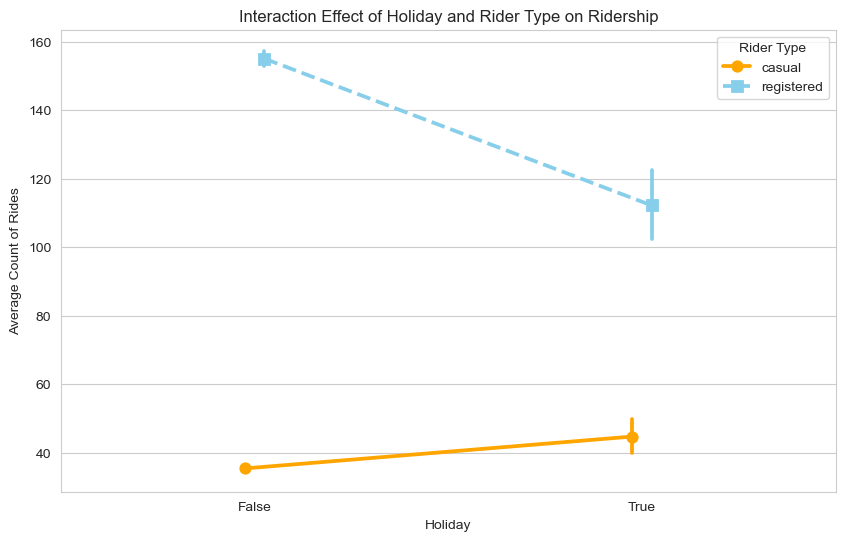

In [10]:
# running anova
# transforming data in long format
reshaped_df = df.melt(id_vars= 'holiday',
                      value_vars=['casual','registered'],
                      value_name= 'count',
                      var_name='rider_type') 
# anova two way
two_way_anova = pg.anova(data= reshaped_df, dv='count', between=['holiday','rider_type'],detailed= True)
print(two_way_anova)
# Checking the means of each variante
means_table = reshaped_df.groupby(['holiday','rider_type'])['count'].mean().reset_index()
print(means_table)

# PLOTTING THE INTERACTION
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.pointplot(data=reshaped_df, 
              x='holiday', 
              y='count',
              hue='rider_type',
              palette=['orange','skyblue'],
              estimator='mean', 
              dodge=True,
              markers=['o','s'],
              linestyles=['-','--'])
              

plt.title('Interaction Effect of Holiday and Rider Type on Ridership')
plt.xlabel('Holiday')
plt.ylabel('Average Count of Rides')
plt.legend(title='Rider Type')
plt.show()


As we reject the null hypothesis and look at our visual, the test reveals that holidays do not affect our rider types (registered vs casual) equally. While registered ridership dropped, casuals increases. This customer behaviour pattern requires targeted business strategy.
The test validate that we have two segments of riders that is affected differently by holidays, marketing, operations, and product teams need to react accordingly to maximize profit and satisfy both segments. As recommendations,Marketing can launch targeted holiday campaigns for casual riders, such as promotions on social medias platforms to reach tourists, targetting holiday activities accessible by bike. Operational team can use this insight to rebalance bike toward recreational areas, during holidays events to catch as most riders as possible and avoid bike rupture on peak stations. Additionnaly this is a good opportunity for product management and marketing teams to create specific features enhancing customer retention by offering promotion and holiday ride packages to new casual riders to exhort them becoming registered riders.

# Part B: Hypothesis Testing 

### Q1 — Commuter pattern:
Do average hourly rides differ between working days and non-working days?
Null hypothesis : There is no difference on average hourly rides between working days and non working days
Alt hypothesis : There is a significant difference on average hourly rides between working days and non working days.

In [76]:
# Count of zero (False) in workingday column
count_zero_workingday = (df['workingday'] == False).sum() 
print("Count of zero (False) in workingday column:", count_zero_workingday)
# Count of one (True) in workingday column
count_one_workingday = (df['workingday'] == True).sum()
print("Count of one (True) in workingday column:", count_one_workingday) # big difference in size

workingday_rides_means = df.groupby('workingday')['cnt'].mean()  # 1 is working day, 0 is not working day
print(workingday_rides_means)

workingday_riders = df.loc[df['workingday'] == True, 'cnt']      # treatment: working day
not_workingday_riders = df.loc[df['workingday'] == False, 'cnt'] # control: non working day

# applying the balancing function 
balanced_sampling_ttest(not_workingday_riders, workingday_riders, n_iter=1000, alternative='two-sided')


Count of zero (False) in workingday column: 5514
Count of one (True) in workingday column: 11865
workingday
False    181.405332
True     193.207754
Name: cnt, dtype: float64
Mean difference: -12.59
Sample1 mean: 181.41, Sample2 mean: 193.99
Power: 0.958
95% CI: [-19.29  -5.89]
p-value: 0.0002


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.683734,11026,two-sided,0.000231,"[-19.29, -5.89]",0.070157,18.744,0.957596


Mean difference: -11.02
Sample1 mean: 181.41, Sample2 mean: 192.43
Power: 0.895
95% CI: [-17.74  -4.3 ]
p-value: 0.0013


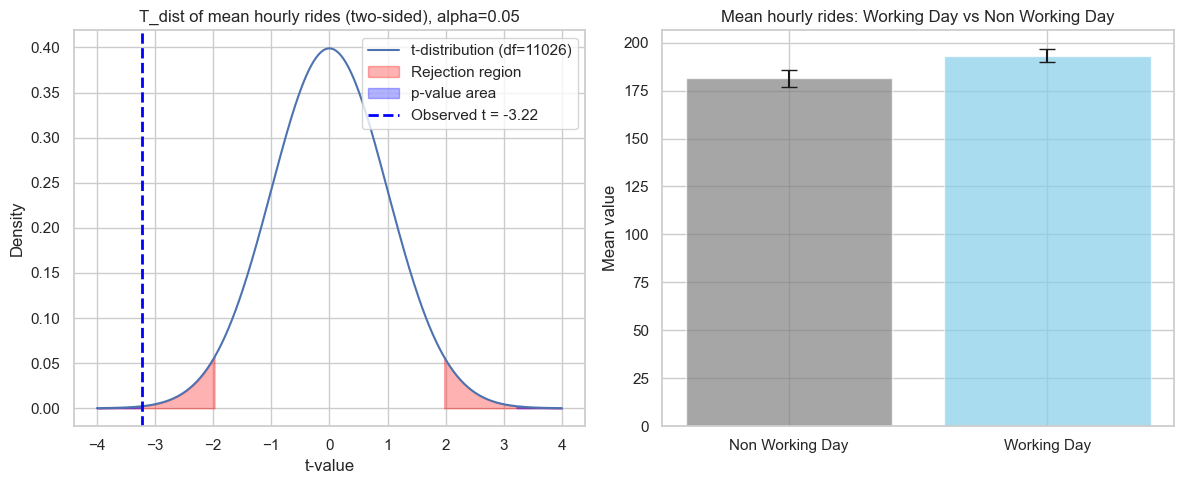

T-statistic = -3.216
p-value = 0.0013
95% CI of mean difference = [-17.740, -4.300]


In [78]:
# Define the plotting function for t-test results
def plot_ttest_with_means(pg_results, control, treatment, alpha=0.05):

    t_stat = pg_results["T"].values[0]
    dfree = pg_results["dof"].values[0]
    pval = pg_results["p-val"].values[0]
    ci_low, ci_high = pg_results["CI95%"].values[0]

    t_crit = t.ppf(1 - alpha/2, dfree)  # two-sided

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # (1) t-distribution visualization
    ax = axes[0]
    x = np.linspace(-4, 4, 400)
    y = t.pdf(x, dfree)
    ax.plot(x, y, label=f't-distribution (df={dfree:.0f})')

    # Rejection regions
    ax.fill_between(x, y, where=(x >= t_crit), color='red', alpha=0.3, label='Rejection region')
    ax.fill_between(x, y, where=(x <= -t_crit), color='red', alpha=0.3)
    # p-value area
    ax.fill_between(x, y, where=(x >= abs(t_stat)), color='blue', alpha=0.3, label='p-value area')
    ax.fill_between(x, y, where=(x <= -abs(t_stat)), color='blue', alpha=0.3)
    # Observed t
    ax.axvline(t_stat, color='blue', linestyle='--', linewidth=2, label=f'Observed t = {t_stat:.2f}')
    ax.set_title(f"T_dist of mean hourly rides (two-sided), alpha={alpha}")
    ax.set_xlabel("t-value")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

    # (2) control treatment means
    ax = axes[1]
    means = [control.mean(), treatment.mean()]
    errors = [
        1.96 * control.std(ddof=1) / np.sqrt(len(control)),
        1.96 * treatment.std(ddof=1) / np.sqrt(len(treatment))
    ]
    ax.bar([0, 1], means, yerr=errors, capsize=6, alpha=0.7, color=['gray', 'skyblue'])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Non Working Day", "Working Day"])
    ax.set_ylabel("Mean value")
    ax.set_title("Mean hourly rides: Working Day vs Non Working Day")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"T-statistic = {t_stat:.3f}")
    print(f"p-value = {pval:.4f}")
    print(f"95% CI of mean difference = [{ci_low:.3f}, {ci_high:.3f}]")
pg_results = balanced_sampling_ttest(not_workingday_riders, workingday_riders, alternative='two-sided')
plot_ttest_with_means(pg_results, not_workingday_riders, workingday_riders)


### Q2 — Multi-group comparison
Do mean hourly rides differ across categories of multi-level categorical variables such
as season or weather condition (choose one)? If you find a difference, describe the
appropriate post-hoc (after the test what other tests would you do) approach and what it
would tell stakeholders

season_name
Winter    111.114569
Spring    208.344069
Summer    236.016237
Fall      198.868856
Name: cnt, dtype: float64


/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_40867/3762218309.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seasons_means.index, y=seasons_means.values, palette='coolwarm')


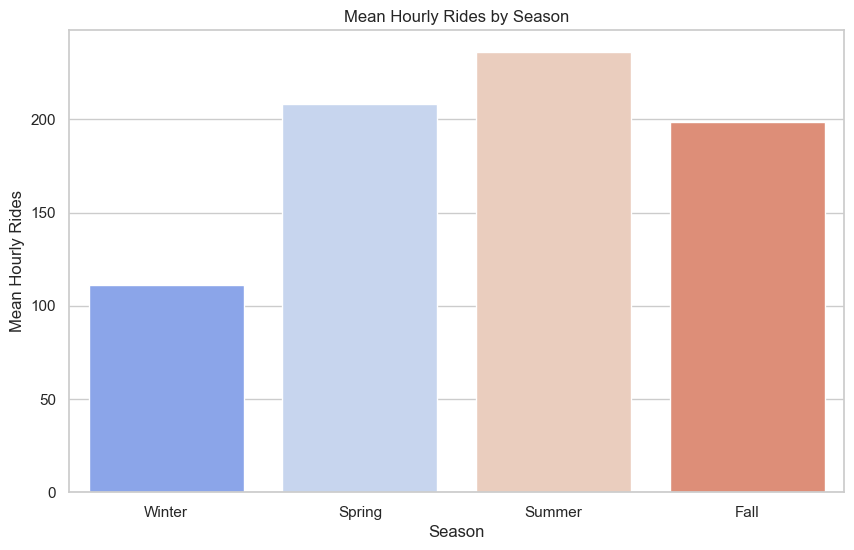

f_statistic = 409.1810372630525 and p_value = 7.40107139971279e-257
        Source            SS     DF            MS           F          p-unc  \
0  season_name  3.772936e+07      3  1.257645e+07  409.181037  7.401071e-257   
1       Within  5.340322e+08  17375  3.073567e+04         NaN            NaN   

        np2  
0  0.065988  
1       NaN  
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
  Fall Spring    9.4752 0.0582   -0.2181   19.1685  False
  Fall Summer   37.1474    0.0   27.5001   46.7946   True
  Fall Winter  -87.7543    0.0  -97.5406   -77.968   True
Spring Summer   27.6722    0.0   18.1252   37.2192   True
Spring Winter  -97.2295    0.0  -106.917   -87.542   True
Summer Winter -124.9017    0.0 -134.5431 -115.2603   True
---------------------------------------------------------


In [80]:
# mapping season numbers to names for clarity
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['season_name'] = df['season'].map(season_map)

# getting the proportions for each season
riders_winter = df.loc[df['season_name'] == 'Winter', 'cnt']
riders_spring = df.loc[df['season_name'] == 'Spring', 'cnt']
riders_summer = df.loc[df['season_name'] == 'Summer', 'cnt']
riders_fall   = df.loc[df['season_name'] == 'Fall', 'cnt']

# Checking the means
seasons_means = df.groupby('season_name')['cnt'].mean()
print(seasons_means)

# Visualizing the means
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=seasons_means.index, y=seasons_means.values, palette='coolwarm')
plt.title("Mean Hourly Rides by Season")
plt.xlabel("Season")
plt.ylabel("Mean Hourly Rides")
plt.show()

# Performing ANOVA using stats and pingouin (to get more details)
f_stat, pvalue = stats.f_oneway(riders_winter, riders_spring, riders_summer, riders_fall)
print(f'f_statistic = {f_stat} and p_value = {pvalue}')
seasons_anova = pg.anova(data=df, dv='cnt', between='season_name', detailed=True)
print(seasons_anova)

# Performing Tukey's post hoc test
post_hoc = pairwise_tukeyhsd(endog=df['cnt'], groups=df['season_name'], alpha=0.05)
print(post_hoc)

## Part C: Simulated A/B Test: Objective
● PM’s objective: Does ridership increase on working days\
during early evening after launching a small app feature
change (it is not necessary to know what was change to\
conduct the analysis)

- Null Hypothesis : There is no difference in the average total bike count between Group A (Pre) and Group B (Post).
- Alt Hypothesis: There is a difference between the average total bike count for Pre_"feature launch" and Post_"feature launch"


In [81]:
# Setting my primary metric as Average hourly rides (cnt) during 17:00–19:00 on working days when weather is good
#● workingday == 1
#● hr ∈ {17, 18, 19}
#● weathersit ∈ {1, 2} and hum ≤ 0.70

df_metric = df[(df['workingday'] == True) & (df['hr'].isin([17,18,19])) & (df['weathersit'].isin([1,2])) & (df['hum'] <= 0.70)]
df_metric

# Setting up my groups for A/B test
#● Pre (Baseline): 2012-08-04 → 2012-08-31 (inclusive)
Pre_baseline = df_metric[(df_metric['dteday'] >= '2012-08-04') & (df_metric['dteday']<='2012-08-31')]

#● Post (Feature On): 2012-09-01 → 2012-09-28 (inclusive)
Post_feature_on = df_metric[(df_metric['dteday'] >= '2012-09-01') & (df_metric['dteday'] <= '2012-09-28')]
# Computing the two means 
baseline_mean = Pre_baseline['cnt'].mean()
feature_on_mean = Post_feature_on['cnt'].mean()
print(f'Baseline Mean: {baseline_mean}')
print(f'Feature On Mean: {feature_on_mean}')

# Conducting the A/B test using a two-sample t-test (paired)
ab_test = pg.ttest(Pre_baseline['cnt'], Post_feature_on['cnt'], alternative='two-sided', correction='auto',paired=True)
print(ab_test)
alpha = 0.05
if (ab_test['p-val']).mean() < alpha:
    print('The mean hourly rides during 17:00-19:00 on working days with good weather is significantly different in the Post (Feature On) period compared to the Pre (Baseline) period. We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis, There is no difference between the means hourly rides of Post compared to Pre .')


Baseline Mean: 739.0188679245283
Feature On Mean: 786.8958333333334
               T        dof alternative     p-val            CI95%   cohen-d  \
T-test -1.780192  95.915498   two-sided  0.078211  [-101.26, 5.51]  0.356121   

         BF10     power  
T-test  0.851  0.424745  
We fail to reject the null hypothesis, There is no difference between the means hourly rides of Post compared to Pre .


/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


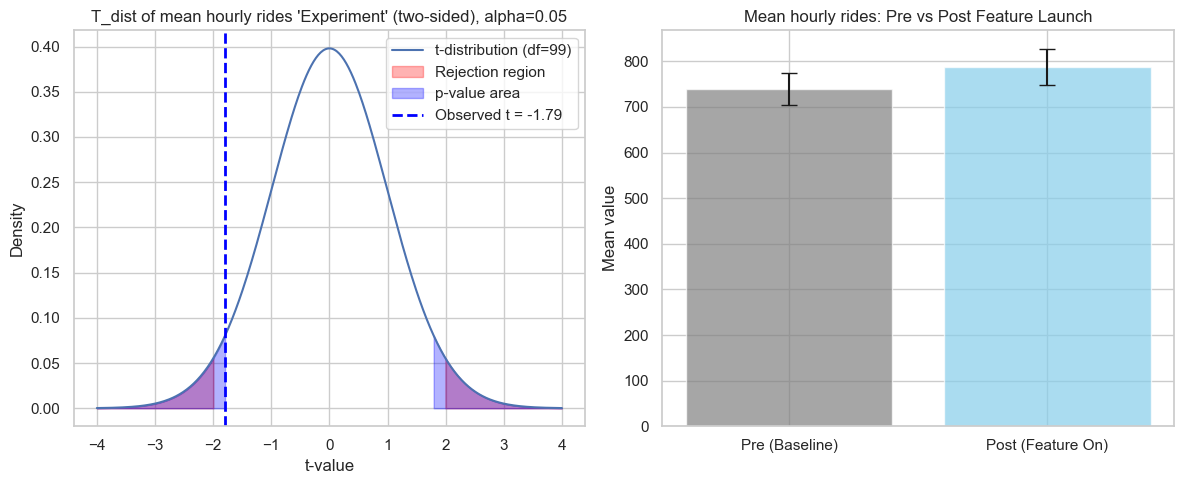

T-statistic = -1.787
p-value = 0.0770
95% CI of mean difference = [-101.030, 5.280]


In [51]:
# plot for the A/B testing results
def plot_ttest_with_means(pg_results, control, treatment, alpha=0.05):
    t_stat = pg_results["T"].values[0]
    dfree = pg_results["dof"].values[0]
    pval = pg_results["p-val"].values[0]
    ci_low, ci_high = pg_results["CI95%"].values[0]

    t_crit = t.ppf(1 - alpha/2, dfree)  # two-sided

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # (1) t-distribution visualization
    ax = axes[0]
    x = np.linspace(-4, 4, 400)
    y = t.pdf(x, dfree)
    ax.plot(x, y, label=f't-distribution (df={dfree:.0f})')

    # Rejection regions
    ax.fill_between(x, y, where=(x >= t_crit), color='red', alpha=0.3, label='Rejection region')
    ax.fill_between(x, y, where=(x <= -t_crit), color='red', alpha=0.3)
    # p-value area
    ax.fill_between(x, y, where=(x >= abs(t_stat)), color='blue', alpha=0.3, label='p-value area')
    ax.fill_between(x, y, where=(x <= -abs(t_stat)), color='blue', alpha=0.3)
    # Observed t
    ax.axvline(t_stat, color='blue', linestyle='--', linewidth=2, label=f'Observed t = {t_stat:.2f}')
    ax.set_title(f"T_dist of mean hourly rides 'Experiment' (two-sided), alpha={alpha}")
    ax.set_xlabel("t-value")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

    # (2) control treatment means
    ax = axes[1]
    means = [control.mean(), treatment.mean()]
    errors = [
        1.96 * control.std(ddof=1) / np.sqrt(len(control)),
        1.96 * treatment.std(ddof=1) / np.sqrt(len(treatment))
    ]
    ax.bar([0, 1], means, yerr=errors, capsize=6, alpha=0.7, color=['gray', 'skyblue'])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Pre (Baseline)", "Post (Feature On)"])
    ax.set_ylabel("Mean value")
    ax.set_title("Mean hourly rides: Pre vs Post Feature Launch")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"T-statistic = {t_stat:.3f}")
    print(f"p-value = {pval:.4f}")
    print(f"95% CI of mean difference = [{ci_low:.3f}, {ci_high:.3f}]")

plot_ttest_with_means(ab_test, Pre_baseline['cnt'], Post_feature_on['cnt'])


### Simulating A/B test for guardrail metrics
- My guardrail metric: Does the feature decreases registered riders counts
- Null Hypothesis : The new feature has no effect on the registered counts
- Alt hypothesis : The new feature is statistically decreasing the registered rider count.
- So what : I want to verify if the little increase caused by the feature, even though not statistically different is mostly for casuals riders which could potentially decreases registered riders engagement.

In [61]:
# Guardrail A/B test: registered riders average instead of cnt
baseline_mean_reg = Pre_baseline['registered'].mean()
feature_on_mean_reg = Post_feature_on['registered'].mean()
print(f'Baseline Registered Mean: {baseline_mean_reg}')
print(f'Feature On Registered Mean: {feature_on_mean_reg}')

# Conducting the A/B test using a two-sample t-test (paired)
ab_test_guardrail = pg.ttest(Pre_baseline['registered'], Post_feature_on['registered'], alternative='greater', correction='True', paired=True)
print(ab_test_guardrail)
alpha = 0.05
if (ab_test_guardrail['p-val']).mean() < alpha:
    print('The mean registered hourly rides during 17:00-19:00 on working days with good weather is significantly different in the Post (Feature On) period compared to the Pre (Baseline) period. We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis, There is no difference between the mean registered hourly rides of Post compared to Pre: NO HARM.')

Baseline Registered Mean: 636.3207547169811
Feature On Registered Mean: 699.75
               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.536306   99     greater  0.993617  [-104.95, inf]  0.505363  0.143   

           power  
T-test  0.000016  
We fail to reject the null hypothesis, There is no difference between the mean registered hourly rides of Post compared to Pre: NO HARM.


/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/pingouin/parametric.py:228: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to paired == False. Check your data.")


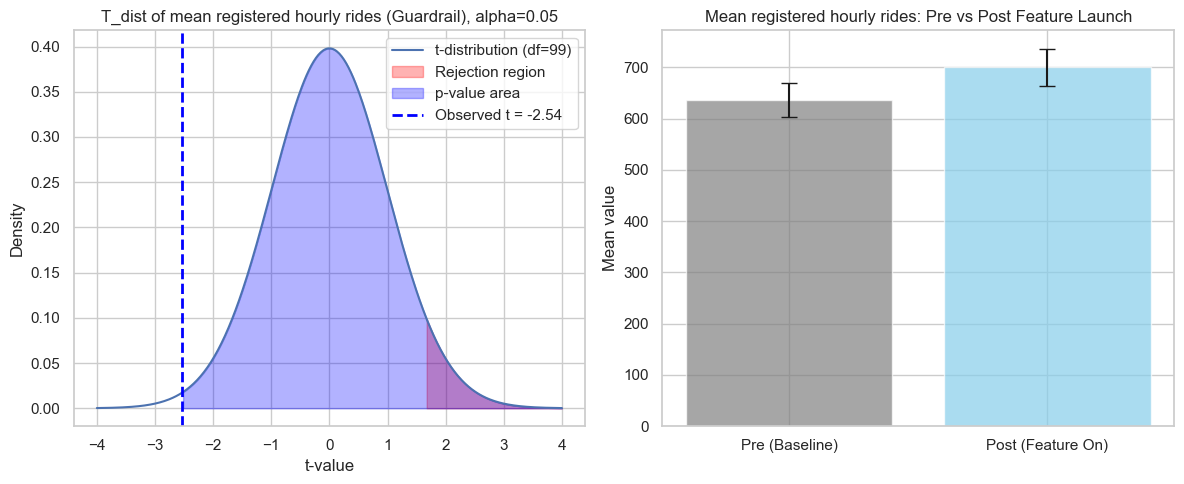

T-statistic = -2.536
p-value = 0.9936
95% CI of mean difference = [-104.950, inf]


In [59]:

# Plotting the guardrail A/B test results (one-sided)
def plot_ttest_with_means(pg_results, control, treatment, alpha=0.05):
    t_stat = pg_results["T"].values[0]
    dfree = pg_results["dof"].values[0]
    pval = pg_results["p-val"].values[0]
    ci_low, ci_high = pg_results["CI95%"].values[0]

    t_crit = t.ppf(1 - alpha, dfree)  # one-sided

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # (1) t-distribution visualization
    ax = axes[0]
    x = np.linspace(-4, 4, 400)
    y = t.pdf(x, dfree)
    ax.plot(x, y, label=f't-distribution (df={dfree:.0f})')
    ax.fill_between(x, y, where=(x >= t_crit), color='red', alpha=0.3, label='Rejection region')
    ax.fill_between(x, y, where=(x >= t_stat), color='blue', alpha=0.3, label='p-value area')
    ax.axvline(t_stat, color='blue', linestyle='--', linewidth=2, label=f'Observed t = {t_stat:.2f}')
    ax.set_title(f"T_dist of mean registered hourly rides (Guardrail), alpha={alpha}")
    ax.set_xlabel("t-value")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)

    # (2) control treatment means
    ax = axes[1]
    means = [control.mean(), treatment.mean()]
    errors = [
        1.96 * control.std(ddof=1) / np.sqrt(len(control)),
        1.96 * treatment.std(ddof=1) / np.sqrt(len(treatment))
    ]
    ax.bar([0, 1], means, yerr=errors, capsize=6, alpha=0.7, color=['gray', 'skyblue'])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Pre (Baseline)", "Post (Feature On)"])
    ax.set_ylabel("Mean value")
    ax.set_title("Mean registered hourly rides: Pre vs Post Feature Launch")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"T-statistic = {t_stat:.3f}")
    print(f"p-value = {pval:.4f}")
    print(f"95% CI of mean difference = [{ci_low:.3f}, {ci_high:.3f}]")

plot_ttest_with_means(ab_test_guardrail, Pre_baseline['registered'], Post_feature_on['registered'])